# Basic visualisation of benchmark LFRic simulations

### Synopsis

This notebook goes through the following steps:
1. Load LFRic output using `iris`, thus representing each of the output variables as `iris.cube.Cube`.
2. Regrid the cubes from unstructured grid to regular rectilinear lat-lon grid using `iris-esmf-regrid`.
3. Average the data over time and/or longitude using functions from `aeolus`.
4. Plot the results and save them to the `../plots/` directory.

Special thanks to Paul Earnshaw for the help with regridding LFRic output.

### Import the necessary libraries

Standard library

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

Scientific stack

In [3]:
import esmf_regrid
import iris
import iris.coord_systems
import iris.fileformats
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from esmf_regrid.experimental.unstructured_scheme import (
    MeshToGridESMFRegridder,
    regrid_unstructured_to_rectilinear,
)
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

# from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [4]:
print(iris.__version__, esmf_regrid.__version__)

3.2.dev0 0.3.dev0


In [5]:
from tqdm.notebook import tqdm

aeolus

In [6]:
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.coord import get_cube_rel_days, get_xy_coords, roll_cube_pm180
from aeolus.io import create_dummy_cube
from aeolus.subset import extract_last_n_days

local scripts

In [7]:
import mypaths
from lfric_util import add_equally_spaced_height_coord
from plot_func import cube_stats_string, figsave, use_style

### Some global definitions

Apply a custom `matplotlib` style.

In [8]:
use_style()

Create a path effects object to highlight contours for later

In [9]:
PE = [PathEffects.withStroke(linewidth=0.5, foreground="w")]

Select the run configuration

In [10]:
planet = "earth"
SIM_LABEL = "Held-Suarez test"
# const = init_const(planet)

Common directory where to save plots.

In [11]:
plot_dir = mypaths.plotdir / "lfric_plots"

### Load the data into a cube list

Use a callback function to attach a level height coordinate for convenience.

Note: adapt the file path to the one on your machine in the `mypaths.py` script.

In [12]:
with PARSE_UGRID_ON_LOAD.context():
    cl = iris.load(
        str(mypaths.topdir.parent / "lfric" / "example" / "lfric_diag.nc"),
        callback=partial(add_equally_spaced_height_coord, model_top_height=32_000),
    )

15-10-2021 18:41:48 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]


Print variable names of different representations of eastward wind.

In [13]:
for cube in cl.extract("eastward_wind"):
    print(f"{cube.long_name:<50} | {cube.var_name:<20}")

eastward_wind: physics predictor                   | u_star1             
physics U wind on W3 points                        | u1_in_w3            
eastward_wind                                      | u1                  
physics U wind on W3 points: physics predictor     | u1_in_w3_star       


Extract the `eastward_wind` in W3 points (otherwise regridding fails for some reason).

In [14]:
u = cl.extract_cube(iris.Constraint(cube_func=lambda cube: cube.var_name == "u1_in_w3"))

### Regrid the data to rectilinear latitude-longitude grid

Create a dummy 2D cube with a UM-like grid. Use +/- 180 degrees to match LFRic, for convenience

In [15]:
tgt_cube = create_dummy_cube(nlat=90, nlon=144, pm180=True)  # Use a non-standard number of points to match UoE SA suites

In [16]:
u_reg = regrid_unstructured_to_rectilinear(u, tgt_cube)
u_reg

<iris 'Cube' of eastward_wind / (ms-1) (time: 160; half_levels: 30; latitude: 90; longitude: 144)>

Check regridding results

In [17]:
u.data.min(), u.data.max()

(-17.650605900475064, 37.04179337120446)

In [18]:
u_reg.data.min(), u_reg.data.max()

(-17.650605900475064, 36.73992251855779)

For regridding many cubes at once, it's better to cache the regridder.

In [19]:
regridder = MeshToGridESMFRegridder(u, tgt_cube)
cl_reg = iris.cube.CubeList()
for cube in cl:
    try:
        cl_reg.append(regridder(cube))
    except (AssertionError, ValueError):
        # For some cubes this fails
        # TODO: investigate!
        pass

### Make a map

In [20]:
def horiz_cross_double(var_key, save=True, add_minmax=True):
    """Make a plot of a horizontal cross-section for LFRic output."""
    _var_plot_dict = VAR_PLOT_DICT[var_key]

    nrows = 1
    ncols = 2
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 9, nrows * 4.5))

    var_name_constr = iris.Constraint(
        cube_func=lambda cube: cube.var_name == _var_plot_dict["var_name"]
    )
    cube_nat = cl.extract_cube(var_name_constr)
    cube_reg = cl_reg.extract_cube(var_name_constr)
    lev_name = [i.name() for i in cube_nat.dim_coords if i.name().endswith("_levels")][0]
    lev_constr = iris.Constraint(**{lev_name: _var_plot_dict["level"]})
    cube_nat = time_mean(cube_nat.extract(lev_constr))
    cube_reg = time_mean(cube_reg.extract(lev_constr))

    # Original data as scatter plot
    ax = axs[0]
    ax.set_title(f"{_var_plot_dict['title']}\nNative grid", loc="left")
    p0 = ax.scatter(
        cube_nat.coord("longitude").points,
        cube_nat.coord("latitude").points,
        c=cube_nat.data,
        **VAR_PLOT_DICT[var_key]["kw_plt"],
    )

    # Regridded data as pcolormesh plot
    ax = axs[1]
    ax.set_title(f"{_var_plot_dict['title']}\nRegridded", loc="left")
    p1 = ax.pcolormesh(
        cube_reg.coord("longitude").points,
        cube_reg.coord("latitude").points,
        cube_reg.data,
        **_var_plot_dict["kw_plt"],
        shading="auto",
    )
    fig.colorbar(p1, ax=axs, pad=0.01)

    for ax in axs.flat:
        ax.set(
            xlim=[-180, 180],
            xticks=np.arange(-180, 181, 60),
            xlabel="Longitude [$\degree$]",
            ylim=[-90, 90],
            yticks=np.arange(-90, 91, 30),
            ylabel="Latitude [$\degree$]",
        )

    if add_minmax:
        at = AnchoredText(cube_stats_string(cube_reg, sep="\n", fmt=".2f"), loc="upper left")
        ax.add_artist(at)

    if save:
        imgname = plot_dir / f"lfric__held_suarez__{var_key}"
        figsave(fig, imgname)

Store all the settings in a common dictionary.

In [21]:
VAR_PLOT_DICT = {
    "theta_in_w3__lev0p5": {
        "title": f"{SIM_LABEL}\nTime mean air potential temperature at level 0.5",
        "var_name": "theta_in_w3",
        "level": 0.5,
        "kw_plt": {"cmap": "plasma", "vmin": 245, "vmax": 310},
    },
    "u1_in_w3__lev0p5": {
        "title": f"{SIM_LABEL}\nTime mean eastward wind at level 0.5",
        "var_name": "u1_in_w3",
        "level": 0.5,
        "kw_plt": {"cmap": "coolwarm", "vmin": -5, "vmax": 5},
    },
}

Saved to ../plots/lfric_plots/lfric__held_suarez__theta_in_w3__lev0p5.png


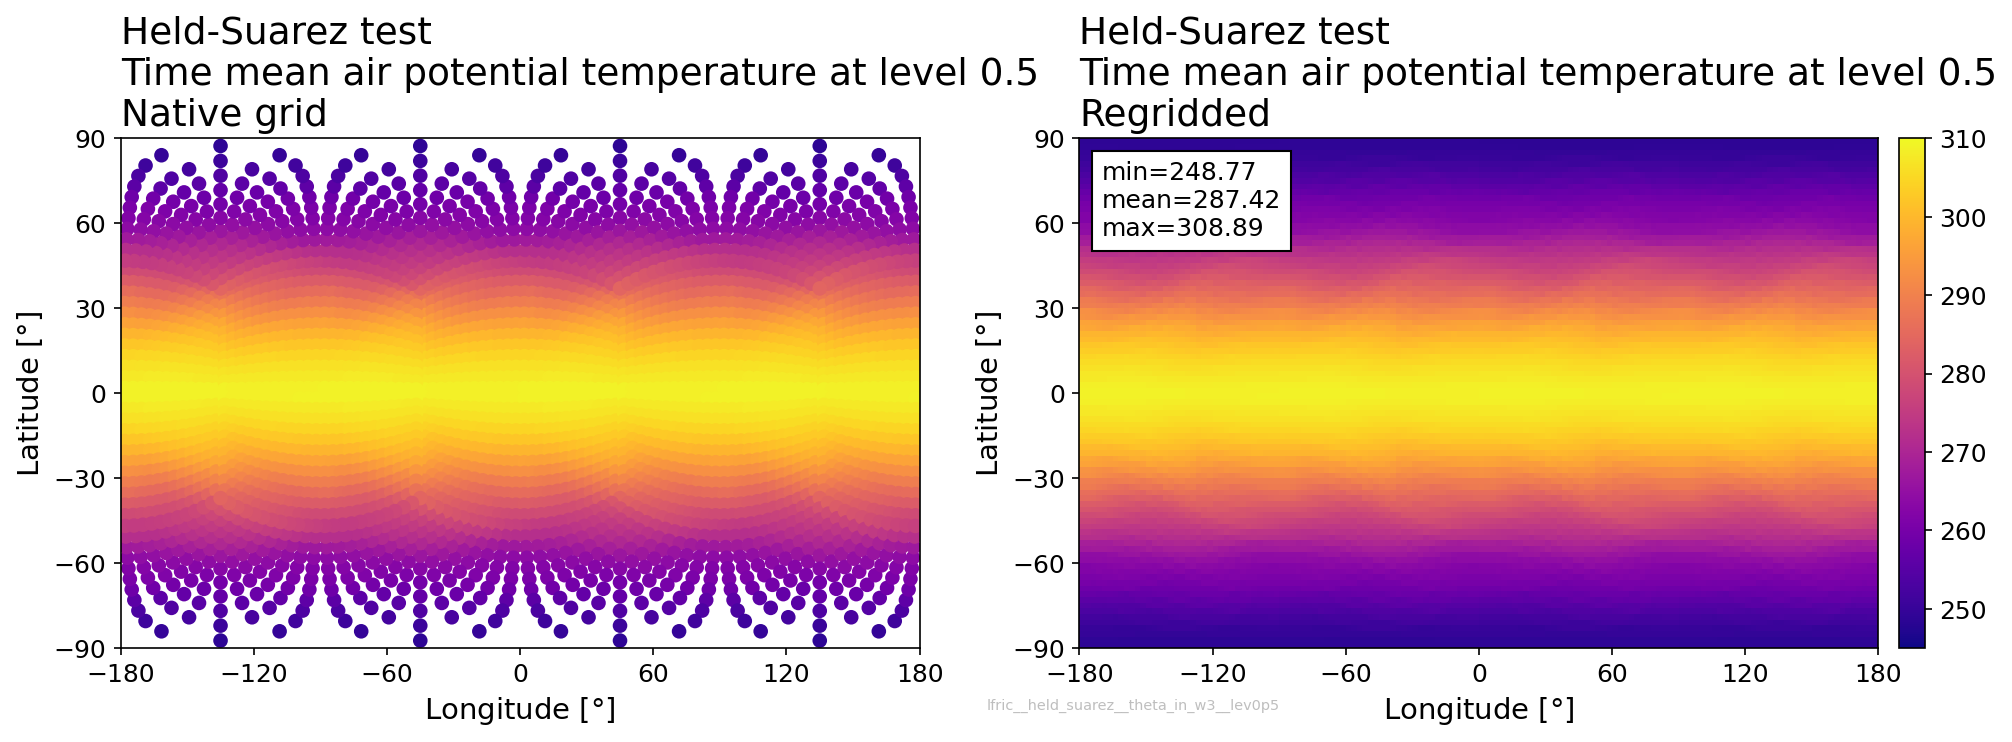

In [22]:
horiz_cross_double("theta_in_w3__lev0p5")

Saved to ../plots/lfric_plots/lfric__held_suarez__u1_in_w3__lev0p5.png


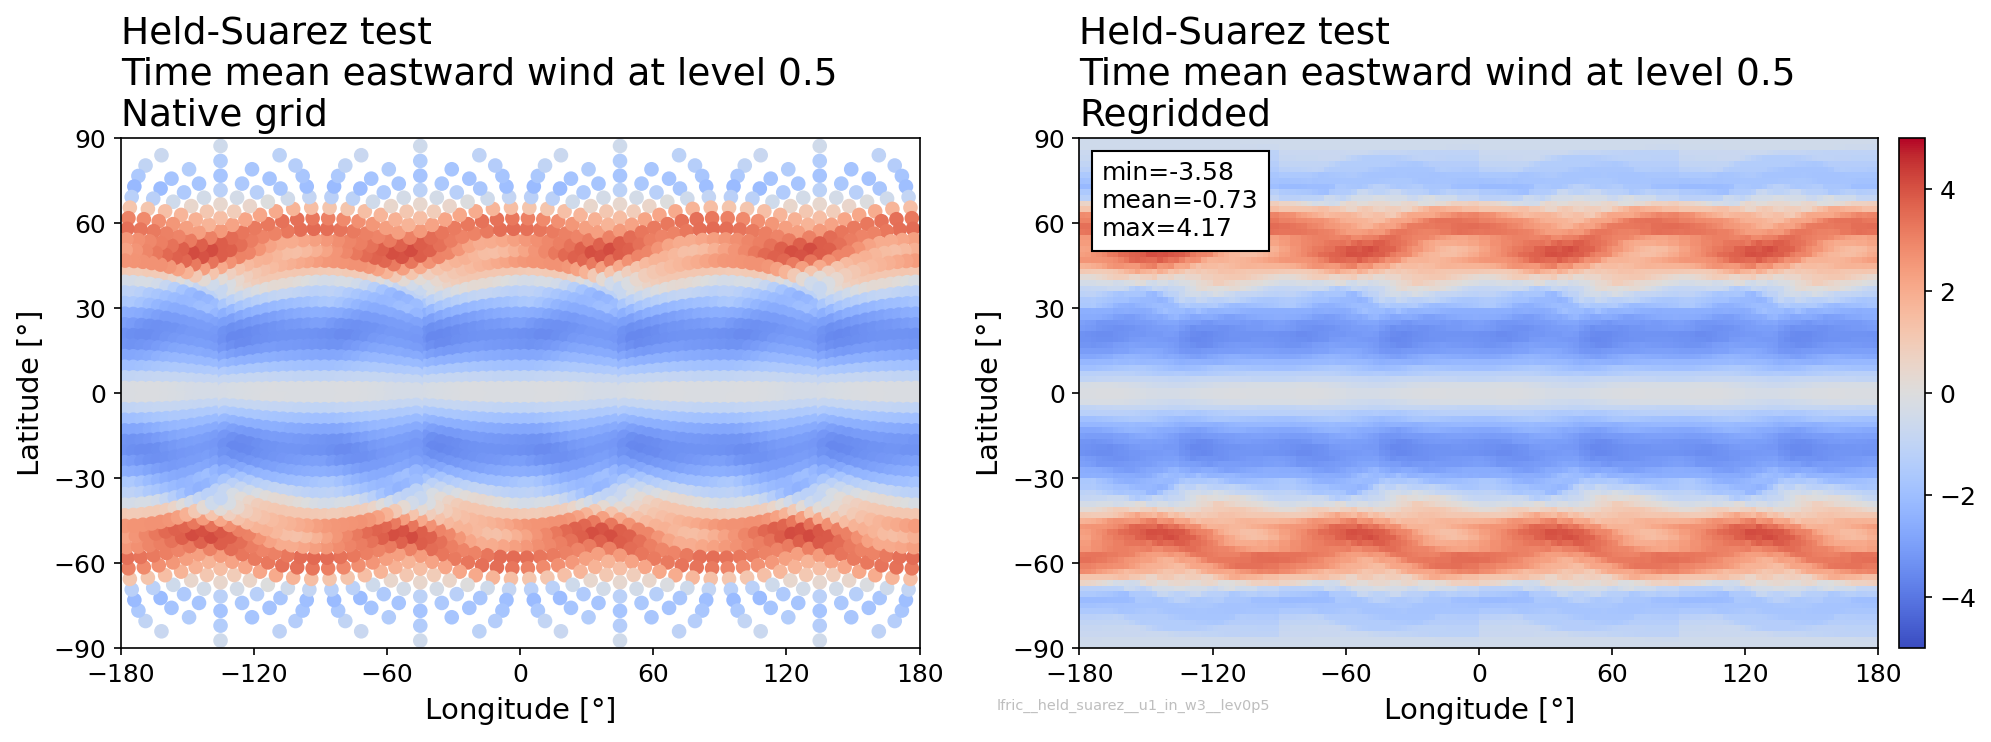

In [23]:
horiz_cross_double("u1_in_w3__lev0p5")

### Make a vertical cross-section

In [24]:
def vert_cross(var_key, save=True, figsize=(9, 4.5)):
    """Make a plot of a vertical cross-section for LFRic output."""
    fig, ax = plt.subplots(figsize=figsize)
    _var_plot_dict = VAR_PLOT_DICT[var_key]

    var_name_constr = iris.Constraint(
        cube_func=lambda cube: cube.var_name == _var_plot_dict["var_name"]
    )
    cube_reg = cl_reg.extract_cube(var_name_constr)
    cube_reg = zonal_mean(time_mean(cube_reg))

    ax.set_title(f"{_var_plot_dict['title']}\nRegridded", loc="left")
    p0 = ax.contourf(
        cube_reg.coord("latitude").points,
        cube_reg.coord("level_height").points,
        cube_reg.data,
        **_var_plot_dict["kw_plt"],
    )
    fig.colorbar(p0, ax=ax, pad=0.01)

    ax.set(
        xlim=[-90, 90],
        xticks=np.arange(-90, 91, 30),
        xlabel="Latitude [$\degree$]",
        ylim=[0, cube_reg.coord("level_height").points.max()],
        ylabel="Height [$m$]",
    )

    if save:
        imgname = plot_dir / f"lfric__held_suarez__{var_key}"
        figsave(fig, imgname)

Store all the settings in a common dictionary.

In [25]:
VAR_PLOT_DICT = {
    "theta_in_w3__tzm": {
        "title": f"{SIM_LABEL}\nTime and zonal mean air potential temperature",
        "var_name": "theta_in_w3",
        "kw_plt": {"cmap": "plasma", "levels": np.arange(250, 850, 25)},
    },
    "u1_in_w3__tzm": {
        "title": f"{SIM_LABEL}\nTime and zonal mean eastward wind",
        "var_name": "u1_in_w3",
        "kw_plt": {"cmap": "coolwarm", "levels": np.arange(-36, 37, 4)},
    },
}

Saved to ../plots/lfric_plots/lfric__held_suarez__theta_in_w3__tzm.png


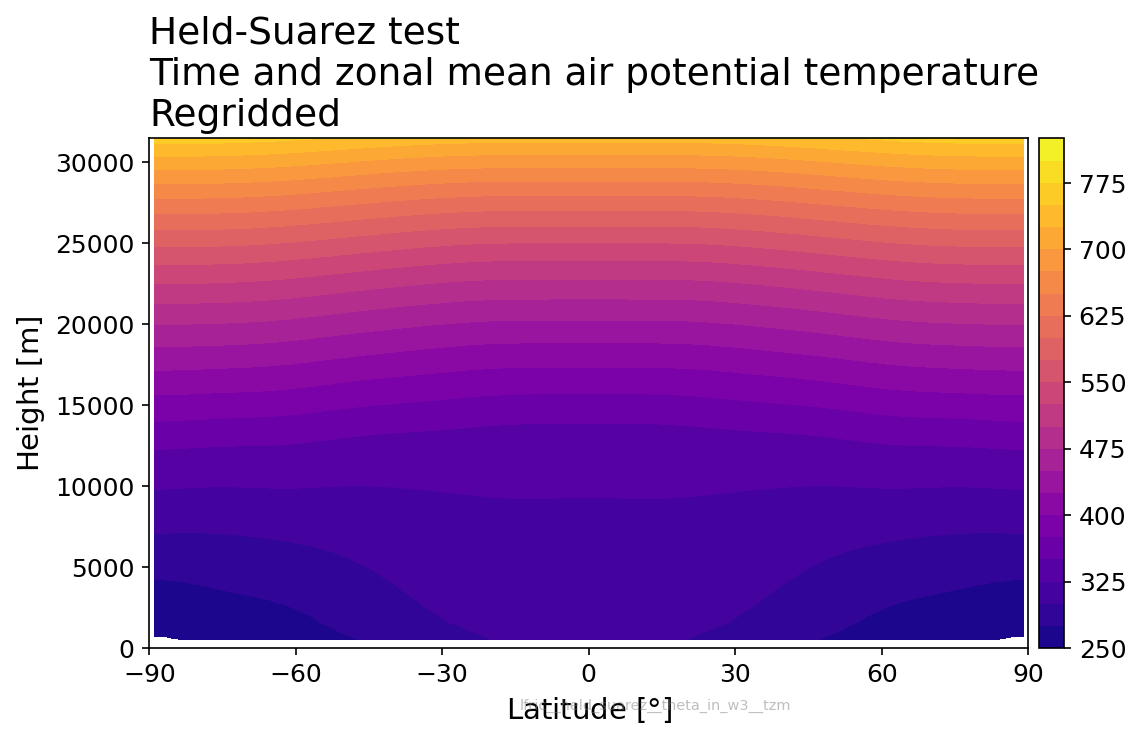

In [26]:
vert_cross("theta_in_w3__tzm")

Saved to ../plots/lfric_plots/lfric__held_suarez__u1_in_w3__tzm.png


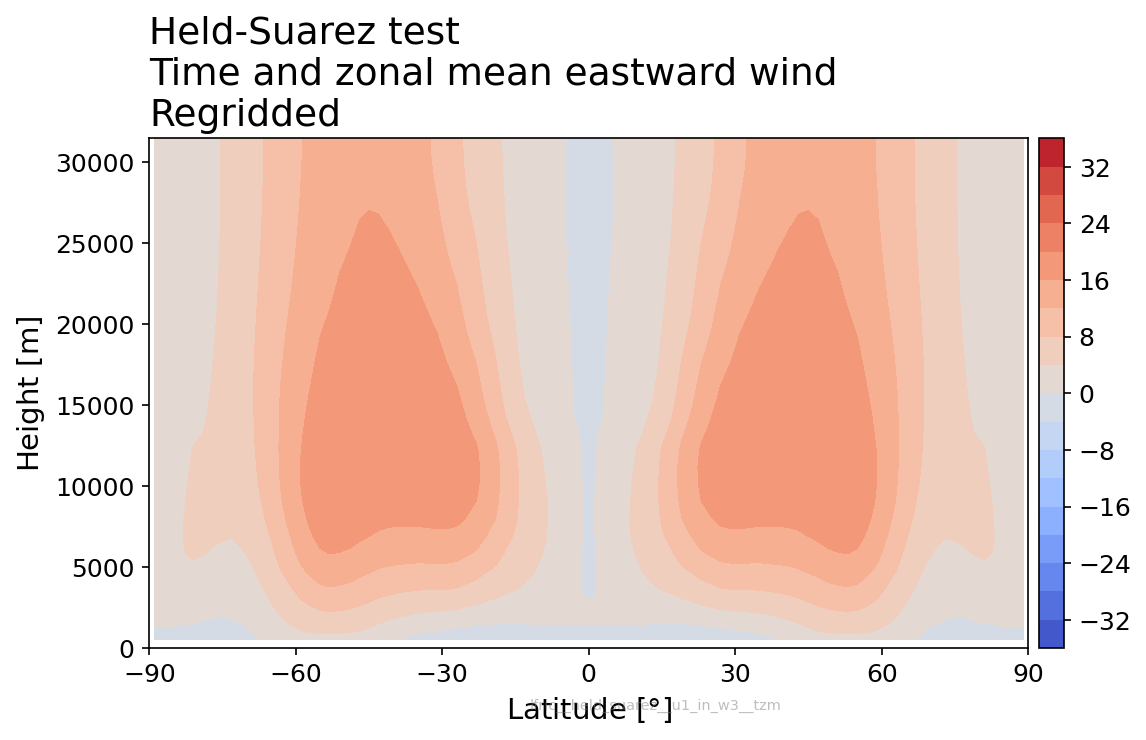

In [27]:
vert_cross("u1_in_w3__tzm")

Calculate regular temperature and plot it separately

In [28]:
temp = cl_reg.extract_cube("theta_in_w3") * cl_reg.extract_cube("exner_pressure")

In [29]:
temp_plot_dict = {
    "title": f"{SIM_LABEL}\nTime and zonal mean air temperature",
    "kw_plt": {"cmap": "coolwarm", "levels": np.arange(190, 321, 10)},
}

In [31]:
def vert_cross_custom(cube_reg, _var_plot_dict, var_key, save=True, figsize=(9, 4.5)):
    """Make a plot of a vertical cross-section for LFRic output."""
    fig, ax = plt.subplots(figsize=figsize)

    cube_reg = zonal_mean(time_mean(cube_reg))

    ax.set_title(f"{_var_plot_dict['title']}\nRegridded", loc="left")
    p0 = ax.contourf(
        cube_reg.coord("latitude").points,
        cube_reg.coord("level_height").points,
        cube_reg.data,
        **_var_plot_dict["kw_plt"],
    )
    fig.colorbar(p0, ax=ax, pad=0.01)

    ax.set(
        xlim=[-90, 90],
        xticks=np.arange(-90, 91, 30),
        xlabel="Latitude [$\degree$]",
        ylim=[0, cube_reg.coord("level_height").points.max()],
        ylabel="Height [$m$]",
    )

    if save:
        imgname = plot_dir / f"lfric__held_suarez__{var_key}"
        figsave(fig, imgname)

Saved to ../plots/lfric_plots/lfric__held_suarez__temp__tzm.png


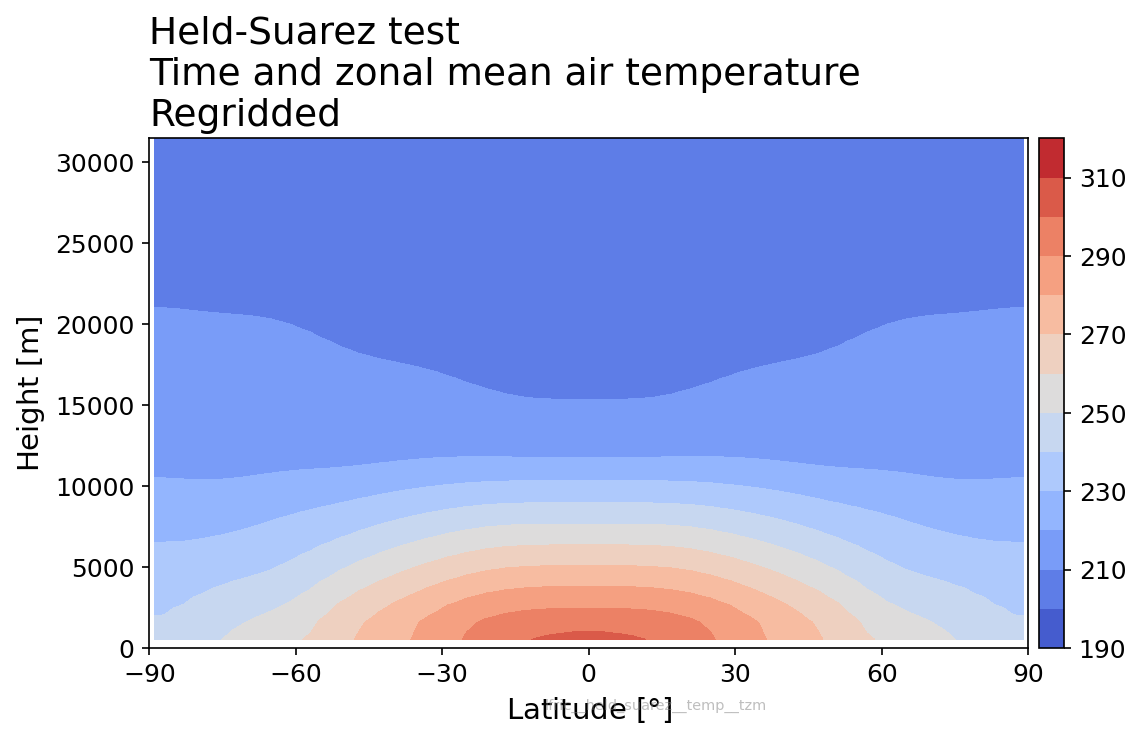

In [84]:
vert_cross_custom(temp, temp_plot_dict, "temp__tzm")